#### Estimación del género de la persona sobre el dataset UTK. Usaremos un modelo de clasificacion, usamos como parte convolucional la red Mobilenet para intentar determinar el género de una persona a partir de una imagen de la cara de la misma. 

#### Importamos las bibliotecas necesarias

In [1]:
#! pip install mlxtend
#! pip install plot_keras_history
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout, LeakyReLU
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from plot_keras_history import plot_history


from sklearn.model_selection import train_test_split


from keras.applications.mobilenet import MobileNet

2024-08-27 11:53:11.486064: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Definimos las rutas del dataset completo y analizamos el número de imágenes

In [2]:
ruta_actual = os.getcwd()
ruta_dataset = os.path.join(ruta_actual,"UTKFace")

numero_imagenes_total = len(os.listdir(ruta_dataset))

numero_imagenes_validacion = round(10*numero_imagenes_total/100)
numero_imagenes_test = numero_imagenes_validacion
numero_imagenes_entrenamiento = numero_imagenes_total - 2*numero_imagenes_validacion

print(f"Número de imágenes total: {numero_imagenes_total}")

print(f"Número de imágenes en entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes en validación: {numero_imagenes_validacion}")
print(f"Número de imágenes en test: {numero_imagenes_test}")

#Un 10% de imágenes para validación y test parece adecuado


Número de imágenes total: 23708
Número de imágenes en entrenamiento: 18966
Número de imágenes en validación: 2371
Número de imágenes en test: 2371


#### Estudiamos el dataset para la característica género

##### Creamos un directorio de nombre genero para almacenar los datasets relativos al género. A su vez dentro de este directorio creamos carpetas de nombres entrenamiento, validacion y test las cuales contendrán en su interior la división del dataset. Dentro de cada una de estas carpetas tendremos las carpetas masculino y femenino.  

In [3]:
#Creamos la carpeta género si no existe
ruta_genero = os.path.join(ruta_actual,"genero")
try:
    os.mkdir(ruta_genero)
except:
    print("La carpeta género ya había sido creada previamente")

#Creamos la carpeta entrenamiento dentro de la carpeta genero
ruta_entrenamiento_genero = os.path.join(ruta_genero,"entrenamiento")
try:
    os.mkdir(ruta_entrenamiento_genero)
except:
    print("La carpeta entrenamiento dentro de la carpeta genero ya fue creada previamente")


#Dentro de la carpeta entrenamiento creamos dos carpetas masculino y femenino para almacenar las imágenes de cada uno de los géneros del conjunto de entrenamiento 
ruta_entrenamiento_masculino = os.path.join(ruta_entrenamiento_genero,"masculino")
ruta_entrenamiento_femenino = os.path.join(ruta_entrenamiento_genero,"femenino")

try:
    os.mkdir(ruta_entrenamiento_masculino)
except:
    print("La carpeta masculino dentro de la carpeta entrenamiento ya estaba creada")

try:
    os.mkdir(ruta_entrenamiento_femenino)
except:
    print("La carpeta femenino dentro de la carpeta entrenamiento ya estaba creada")


#Creamos la carpeta validacion dentro de la carpeta genero
ruta_validacion_genero = os.path.join(ruta_genero,"validacion")
try:
    os.mkdir(ruta_validacion_genero)
except:
    print("La carpeta validacion dentro de la carpeta genero ya fue creada previamente")

#Dentro de la carpeta validacion creamos dos carpetas masculino y femenino para almacenar las imágenes de cada uno de los géneros del conjunto de entrenamiento 
ruta_validacion_masculino = os.path.join(ruta_validacion_genero,"masculino")
ruta_validacion_femenino = os.path.join(ruta_validacion_genero,"femenino")

try:
    os.mkdir(ruta_validacion_masculino)
except:
    print("La carpeta masculino dentro de la carpeta validacion ya estaba creada")

try:
    os.mkdir(ruta_validacion_femenino)
except:
    print("La carpeta femenino dentro de la carpeta validacion ya estaba creada")


#Creamos la carpeta test dentro de la carpeta genero
ruta_test_genero = os.path.join(ruta_genero,"test")
try:
    os.mkdir(ruta_test_genero)
except:
    print("La carpeta test dentro de la carpeta genero ya fue creada previamente")

#Dentro de la carpeta validacion creamos dos carpetas masculino y femenino para almacenar las imágenes de cada uno de los géneros del conjunto de entrenamiento 
ruta_test_masculino = os.path.join(ruta_test_genero,"masculino")
ruta_test_femenino = os.path.join(ruta_test_genero,"femenino")

try:
    os.mkdir(ruta_test_masculino)
except:
    print("La carpeta masculino dentro de la carpeta validacion ya estaba creada")

try:
    os.mkdir(ruta_test_femenino)
except:
    print("La carpeta femenino dentro de la carpeta validacion ya estaba creada")


#### Usamos train_test_split para separar el dataset por género de manera estratificada (conservando las proporciones para cada género en entrenameiento, validación y test)

#### Realizamos la división de las imágenes en entrenamiento, validación y test de manera estratificada:

In [4]:
nombres_dataset = os.listdir(ruta_dataset)

etiquetas_dataset = []

for nombre in nombres_dataset:
    etiqueta = nombre.split("_")[1]
    etiquetas_dataset.append(etiqueta)

# 80% de las imágenes para entrenamiento, 10% para validación y 10% para test 
nombres_entrenamiento, nombres_temporal, etiquetas_entrenamiento, etiquetas_temporal = train_test_split(nombres_dataset, etiquetas_dataset,stratify=etiquetas_dataset, test_size=0.2 ,random_state=42)

nombres_validacion, nombres_test, etiquetas_validacion, etiquetas_test = train_test_split(nombres_temporal, etiquetas_temporal, test_size=0.5, stratify=etiquetas_temporal, random_state=42)


#### Guardamos las imágenes en las carpetas en base a la estratificación
#### Género 0->masculino, 1->femenino

##### Guardamos imágenes de entrenamiento

In [5]:
for indice, nombre in enumerate(nombres_entrenamiento):
    if etiquetas_entrenamiento[indice] == '0':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_entrenamiento_masculino)
    elif etiquetas_entrenamiento[indice] == '1':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_entrenamiento_femenino)
    else:
        print("Hubo algún error con las etiquetas de las imágenes")
    

##### Guardamos imágenes en validación

In [6]:
for indice, nombre in enumerate(nombres_validacion):
    if etiquetas_validacion[indice] == '0':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_validacion_masculino)
    elif etiquetas_validacion[indice] == '1':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_validacion_femenino)
    else:
        print("Hubo algún error con las etiquetas de las imágenes")

##### Guardamos imágenes en test

In [7]:
for indice, nombre in enumerate(nombres_test):
    if etiquetas_test[indice] == '0':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_test_masculino)
    elif etiquetas_test[indice] == '1':
        shutil.copy(os.path.join(ruta_dataset,nombre),ruta_test_femenino)
    else:
        print("Hubo algún error con las etiquetas de las imágenes")

#### Creamos los datasets usando la api tf.data.Dataset

In [8]:
#Las imágenes tienen tamaños reales de 200 píxeles x 200 píxeles
alto = 224
ancho = 224

#Elegimos el tamaño de lote como 64:
tamano_lote = 32

#Definimos funciones para preprocesar las imágenes a partir de la ruta
def cargar_preprocesar_imagen(ruta):
    parts = tf.strings.split(ruta, os.path.sep)
    etiqueta_tensor = parts[-2]
    if etiqueta_tensor.numpy() == b'masculino':
        etiqueta_asignada = 0.0 
    else: 
        # En este caso etiqueta_tensor.numpy() == b'femenino':
        etiqueta_asignada = 1.0
    
    etiqueta = tf.constant(etiqueta_asignada,dtype=tf.float32)
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)
    imagen = tf.image.resize(imagen, [alto, ancho])
    imagen = imagen / 255.0  # Normalizar a [0, 1]
    return imagen, etiqueta

# Función de envoltura para tf.py_function
def cargar_preprocesar_imagen_con_etiqueta(ruta):
    imagen, etiqueta = tf.py_function(cargar_preprocesar_imagen, [ruta], [tf.float32, tf.float32])
    imagen.set_shape((alto, ancho, 3))  # Asegurar que la imagen tenga la forma correcta
    etiqueta.set_shape(())  # La etiqueta es un escalar
    #etiqueta = tf.one_hot(etiqueta, 2)  # Convertir la etiqueta a one-hot encoding
    return imagen, etiqueta


######## DATASET ENTRENAMIENTO ############
# Cargamos las imágenes desde el directorio de entrenamiento. Las imágenes son preprocesadas y preparadas para entrenar la red.
dataset_entrenamiento = tf.data.Dataset.list_files(ruta_entrenamiento_genero + '/*/*.jpg')
dataset_entrenamiento = dataset_entrenamiento.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No hemos definido una función para hacer data augmentation (En principio no haremos data augmentation)
#dataset_entrenamiento = dataset_entrenamiento.map(aumento_imagenes, num_parallel_calls=tf.data.AUTOTUNE)

#barajamos el dataset
dataset_entrenamiento = dataset_entrenamiento.shuffle(buffer_size=1000)
#Hacemos los lotes del dataset del tamaño especificado
dataset_entrenamiento = dataset_entrenamiento.batch(tamano_lote)
dataset_entrenamiento = dataset_entrenamiento.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.repeat()  # Añadir repeat() para que se itere sobre el dataset una vez que se acaben los bastches


######## DATASET VALIDACIÓN ############
# Cargamos las imágenes desde el directorio de validación. Las imágenes son preprocesadas y preparadas para validar la red.
dataset_validacion = tf.data.Dataset.list_files(ruta_validacion_genero + '/*/*.jpg')

#Preprocesamos las imágenes
dataset_validacion = dataset_validacion.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No necesitamos barajar el dataset de validación
#dataset_validacion = dataset_validacion.shuffle(buffer_size=100)
#dataset_validacion = dataset_validacion.cache() #No se debe usar (nos quedamos sin ram) 

#Hacemos los lotes del dataset del tamaño especificado
dataset_validacion = dataset_validacion.batch(tamano_lote)
dataset_validacion = dataset_validacion.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.repeat()




######## DATASET TEST ############
# Cargar las imágenes desde el directorio de test. Si se desean entrenar otros modelos, se usarán estas imágenes para ver cual de ellos es el mejor
dataset_test = tf.data.Dataset.list_files(ruta_test_genero + '/*/*.jpg')
dataset_test = dataset_test.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#dataset_test = dataset_test.cache() #Nos quedamos sin ram si activamos esta opción
dataset_test = dataset_test.batch(tamano_lote)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.repeat()

######## IMÁGENES DE CADA CONJUNTO ############
# Número de imágenes en el conjunto de entrenamiento, validación Y test
numero_imagenes_entrenamiento = sum([len(files) for r, d, files in os.walk(ruta_entrenamiento_genero)])
numero_imagenes_validacion = sum([len(files) for r, d, files in os.walk(ruta_validacion_genero)])
numero_imagenes_test = sum([len(files) for r, d, files in os.walk(ruta_test_genero)])


2024-08-27 11:53:13.252968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-27 11:53:13.270483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-27 11:53:13.270588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-27 11:53:13.271537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [9]:
print(f"Número de imágenes para entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes para validación: {numero_imagenes_validacion}")
print(f"Número de imágenes para test: {numero_imagenes_test}")

Número de imágenes para entrenamiento: 18966
Número de imágenes para validación: 2371
Número de imágenes para test: 2371


#### Definimos la arquitectura del modelo, haciendo transfer learning del modelo mobileNet

In [10]:
def mobileNet_genero(alto_imagen = alto, ancho_imagen = ancho):
  #Definimos el tensor (imagen) de entrad en 3 canales
  tensor_entrada = Input(shape=(alto_imagen, ancho_imagen, 3))

  #Instanciamos la arquitectura de la red MobilNet
  mobileNet_genero = MobileNet(input_tensor = tensor_entrada, include_top=False, weights = "imagenet")

  ultima_capa = mobileNet_genero.layers[-1].output
  x= Flatten(name='flatten')(ultima_capa)
  x = Dense(64, activation='relu', name='fc1')(x)
  x = Dense(32, activation='relu', name='fc2')(x)
  salida = Dense(1, activation='sigmoid', name='genero')(x)
  modelo_genero = Model(tensor_entrada, salida)

  #Congelamos los pesos de la capa convolucional (mantenemos los de la red MobileNet que fueron entrenados sobre ImageNet)
  #for capa in modelo_genero.layers[:-4]:
#	  capa.trainable = False

  return modelo_genero

#### Instanciamos el modelo creado

In [11]:
modelo = mobileNet_genero()
modelo.summary()
# No tenemos muchos datos, pero el modelo es bastante grande

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

#### Definimos el optimizador, función de pérdida, early stopping y disminución de learning rate si no mejora el entrenamiento. También realizamos la compilación del modelo.

##### Definimos la tasa de aprendizaje y el optimizador deseado (Adam)

In [12]:
tasa_aprendizaje = 0.001 #Con lr=0.001 se obtiene 0.88 de accuracy No mejora pese a aumentar el tamaño de batch o bajar el learning rate (Vamos a entrenar descongelando los pesos)
optimizador =  Adam(learning_rate = tasa_aprendizaje)

##### Definimos parada temprana (EarlyStopping)

In [13]:
# Early stopping
parada_temprana = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

##### Definimos la caida del learning rate si el val_loss no mejora tras 5 épocas

In [14]:
# Reduce Learning rate on Plateau
reducir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6)


#### Compilamos el modelo

In [15]:
modelo.compile(optimizer=optimizador,loss = BinaryCrossentropy(), metrics=["accuracy",Recall(), Precision()] )

#### Calculamos los pasos de entrenamiento, de validación y del test del modelo

In [16]:
if numero_imagenes_entrenamiento % tamano_lote == 0:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote
else:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote +1

if numero_imagenes_validacion % tamano_lote == 0:
    pasos_validacion = numero_imagenes_validacion // tamano_lote
else:
    pasos_validacion = numero_imagenes_validacion // tamano_lote +1

if numero_imagenes_test % tamano_lote == 0:
    pasos_test = numero_imagenes_test // tamano_lote
else:
    pasos_test = numero_imagenes_test // tamano_lote +1


print(f"Número de pasos de entrenamiento para un batch size de {tamano_lote}: {pasos_entrenamiento}")
print(f"Número de pasos de validación para un batch size de {tamano_lote}: {pasos_validacion}")
print(f"Número de pasos de test para un batch size de para un batch size de {tamano_lote}: {pasos_test}")

Número de pasos de entrenamiento para un batch size de 32: 593
Número de pasos de validación para un batch size de 32: 75
Número de pasos de test para un batch size de para un batch size de 32: 75


#### Entrenamos por 100 épocas la red. El entrenamiento parará antes a causa del early stopping

In [17]:
# Entrenamiento del modelo
numero_epocas = 100

historia = modelo.fit(
    dataset_entrenamiento,
    epochs=numero_epocas,
    validation_data=dataset_validacion,
    steps_per_epoch=pasos_entrenamiento,
    validation_steps=pasos_validacion,
    callbacks=[parada_temprana, reducir_lr]
)

Epoch 1/100


2024-08-27 11:53:18.358551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-08-27 11:53:18.956764: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-27 11:53:18.956783: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-08-27 11:53:18.956853: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-27 11:53:19.610253: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


593/593 [==============================] - 138s 223ms/step - loss: 0.3323 - accuracy: 0.8747 - recall: 0.8743 - precision: 0.8647 - val_loss: 0.2457 - val_accuracy: 0.8996 - val_recall: 0.8772 - val_precision: 0.9093 - lr: 0.0010
Epoch 2/100
593/593 [==============================] - 134s 222ms/step - loss: 0.2063 - accuracy: 0.9154 - recall: 0.9160 - precision: 0.9076 - val_loss: 0.2591 - val_accuracy: 0.8937 - val_recall: 0.9549 - val_precision: 0.8432 - lr: 0.0010
Epoch 3/100
593/593 [==============================] - 134s 221ms/step - loss: 0.1749 - accuracy: 0.9278 - recall: 0.9271 - precision: 0.9221 - val_loss: 0.2754 - val_accuracy: 0.8908 - val_recall: 0.7986 - val_precision: 0.9668 - lr: 0.0010
Epoch 4/100
593/593 [==============================] - 134s 221ms/step - loss: 0.1692 - accuracy: 0.9340 - recall: 0.9336 - precision: 0.9286 - val_loss: 0.2553 - val_accuracy: 0.9148 - val_recall: 0.9373 - val_precision: 0.8901 - lr: 0.0010
Epoch 5/100
593/593 [=======================

#### Guardamos los pesos de la red entrenada

In [18]:
modelo.save("modelo_genero.h5")

#### Podemos cargar los pesos del modelo

In [19]:
modelo_cargado = load_model("modelo_genero.h5")

### Analizamos los resultados (accuracy, recall, precision, f1_score, matriz de confusión, ...) sobre el conjunto de entrenamiento y validación

###### Se muestran gráficas con el loss, accuracy, precision y recall del entrenamiento

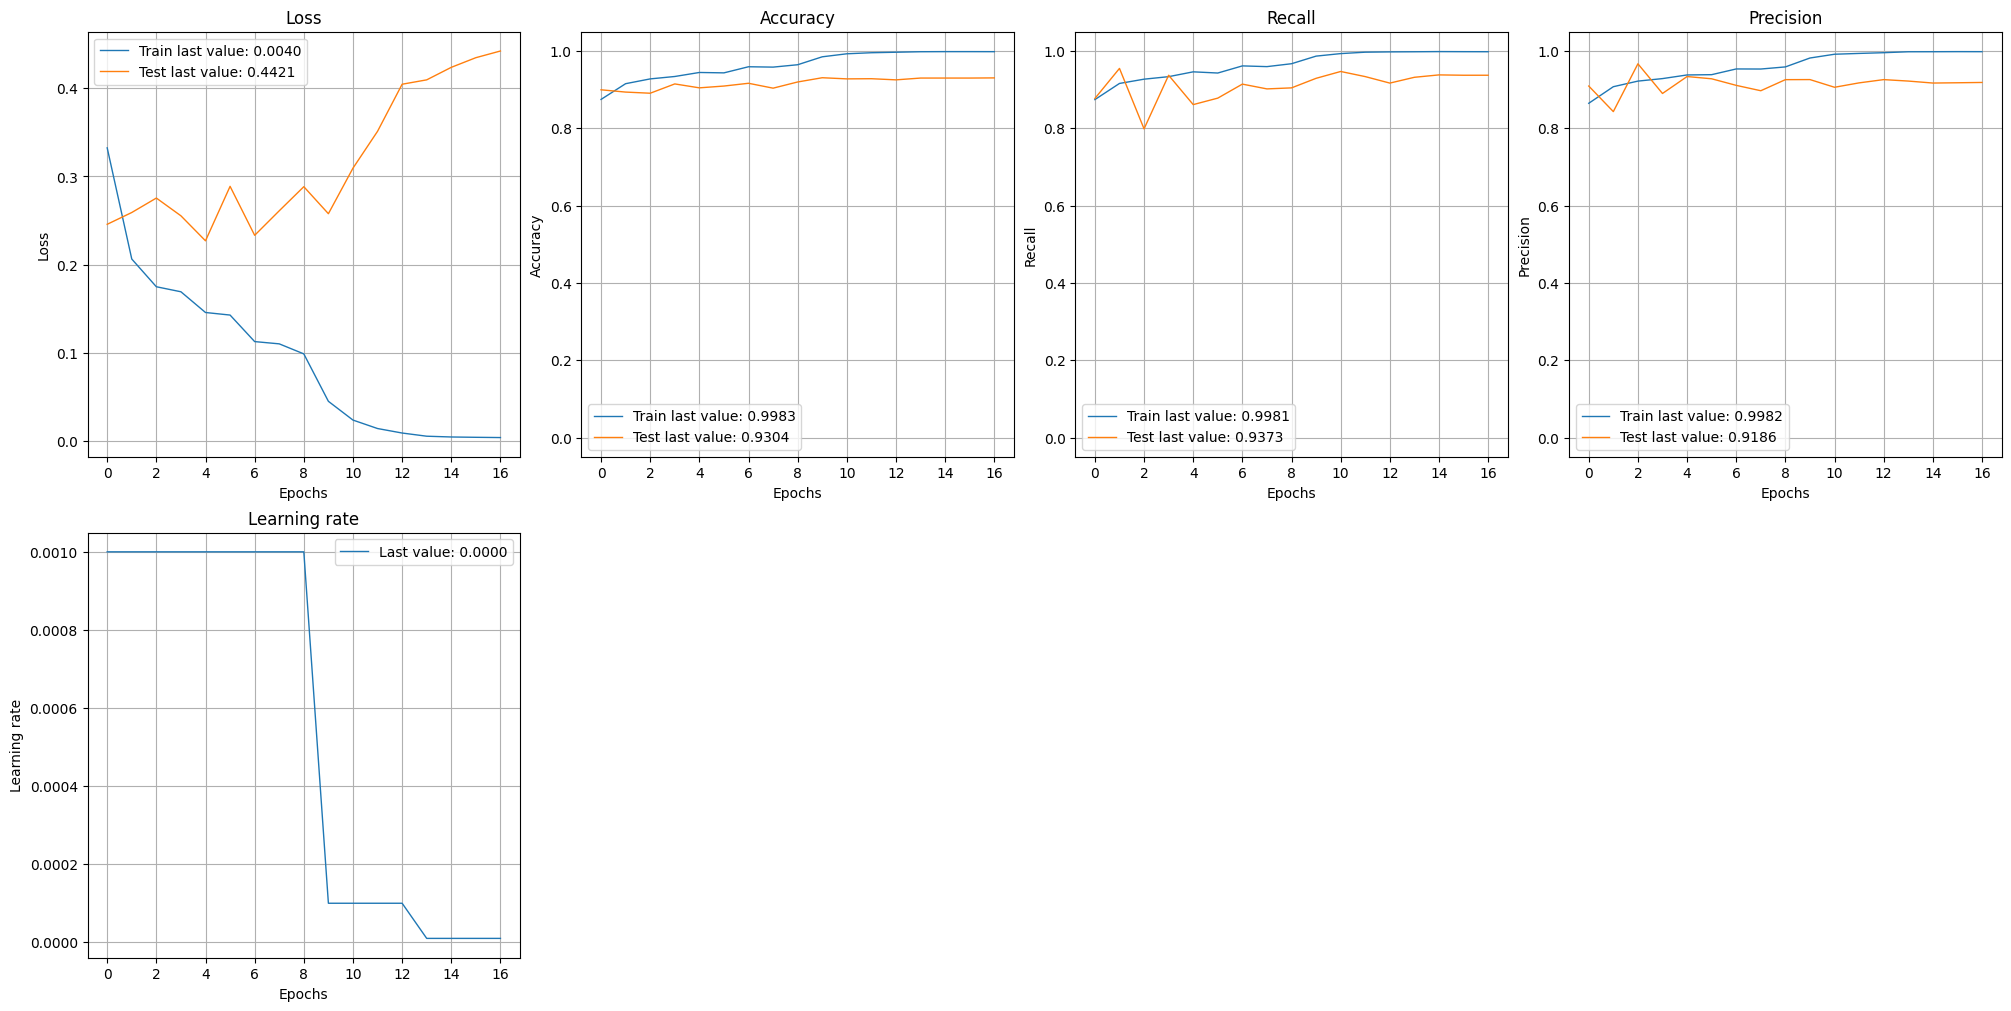

In [20]:
#Mostramos gráficas de interes del entrenamiento en función de las épocas

#from plot_keras_history import plot_history
plot_history(historia)
plt.show()

##### Calculamos la matriz de confusión para el conjunto de entrenamiento. Primero hacemos el cómputo necesario

In [21]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_entrenamiento = np.array([])
etiquetas_entrenamiento = np.array([])

generador_entrenamiento = dataset_entrenamiento.take(pasos_entrenamiento).as_numpy_iterator()

for iteracion in range(pasos_entrenamiento):
    
    lote = generador_entrenamiento.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_entrenamiento = np.concatenate((prediccion_entrenamiento, prediccion_lote), axis=0)

    etiquetas_entrenamiento = np.concatenate((etiquetas_entrenamiento, etiquetas), axis=0)

1/1 [==============================] - 0s 150ms/step


[[9672  241]
 [ 752 8301]]


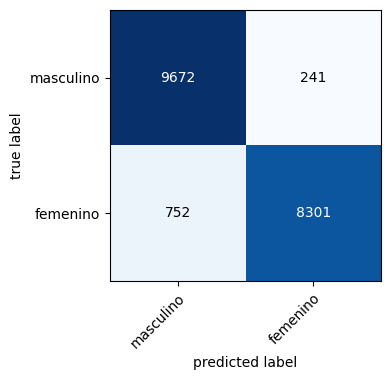

In [22]:
#Calculamos la matriz de confusión en entrenamiento y la mostramos
matriz_confusion_entrenamiento = confusion_matrix(etiquetas_entrenamiento,prediccion_entrenamiento)

print(matriz_confusion_entrenamiento)

%matplotlib inline

etiquetas = ['masculino','femenino']

plot_confusion_matrix(conf_mat = matriz_confusion_entrenamiento, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [23]:
print(classification_report(etiquetas_entrenamiento,prediccion_entrenamiento, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9279    0.9757    0.9512      9913
         1.0     0.9718    0.9169    0.9436      9053

    accuracy                         0.9476     18966
   macro avg     0.9498    0.9463    0.9474     18966
weighted avg     0.9488    0.9476    0.9475     18966



##### Calculamos la matriz de confusión sobre el conjunto de validación. Primero hacemos el cómputo necesario

In [24]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_validacion = np.array([])
etiquetas_validacion = np.array([])

generador_validacion = dataset_validacion.take(pasos_validacion).as_numpy_iterator()

for iteracion in range(pasos_validacion):
    
    lote = generador_validacion.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_validacion = np.concatenate((prediccion_validacion, prediccion_lote), axis=0)

    etiquetas_validacion = np.concatenate((etiquetas_validacion, etiquetas), axis=0)


1/1 [==============================] - 0s 11ms/step


[[1170   69]
 [ 157  975]]


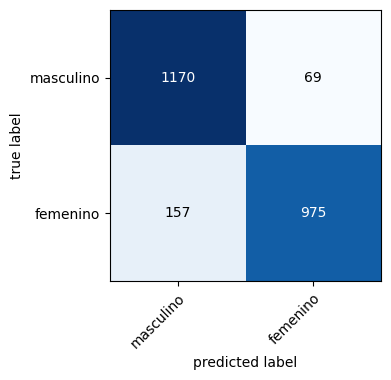

In [25]:
#Calculamos la matriz de confusión en validación y la mostramos
matriz_confusion_validacion = confusion_matrix(etiquetas_validacion,prediccion_validacion)

print(matriz_confusion_validacion)

%matplotlib inline

etiquetas = ['masculino','femenino']

plot_confusion_matrix(conf_mat = matriz_confusion_validacion, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [26]:
print(classification_report(etiquetas_validacion,prediccion_validacion, digits = 4))

              precision    recall  f1-score   support

         0.0     0.8817    0.9443    0.9119      1239
         1.0     0.9339    0.8613    0.8961      1132

    accuracy                         0.9047      2371
   macro avg     0.9078    0.9028    0.9040      2371
weighted avg     0.9066    0.9047    0.9044      2371



## Hacemos exactamente lo mismo pero sobre el conjunto de test. Esto lo podemos usar para comparar los resultados con otras arquitecturas de red distintas a la usada.

### Analizamos los resultados (accuracy, recall, precision, f1_score, matriz de confusión, ...) sobre el conjunto de test. Para ello mostramos la matriz de confusión y el informe de clasificación

In [27]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_test = np.array([])
etiquetas_test = np.array([])

generador_test = dataset_test.take(pasos_test).as_numpy_iterator()


for iteracion in range(pasos_test):
    
    lote = generador_test.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_test = np.concatenate((prediccion_test, prediccion_lote), axis=0)

    etiquetas_test = np.concatenate((etiquetas_test, etiquetas), axis=0)


1/1 [==============================] - 0s 13ms/step


[[1182   57]
 [ 146  986]]


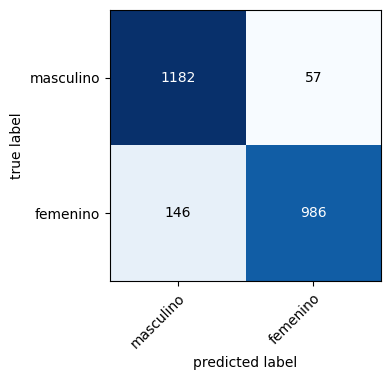

In [28]:
#Calculamos la matriz de confusión sobre el conjunto de test y la mostramos
matriz_confusion_test = confusion_matrix(etiquetas_test,prediccion_test)

print(matriz_confusion_test)

%matplotlib inline

etiquetas = ['masculino','femenino']

plot_confusion_matrix(conf_mat = matriz_confusion_test, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [29]:
print(classification_report(etiquetas_test,prediccion_test, digits = 4))

              precision    recall  f1-score   support

         0.0     0.8901    0.9540    0.9209      1239
         1.0     0.9453    0.8710    0.9067      1132

    accuracy                         0.9144      2371
   macro avg     0.9177    0.9125    0.9138      2371
weighted avg     0.9165    0.9144    0.9141      2371



### OBSERVACIONES SOBRE LOS RESULTADOS:

#### Mostramos imágenes del dataset de validación, junto con la predicción del modelo para las imágenes clasificadas correctamente y las clasificadas erroneamente.

In [30]:

#Imágenes genero masculino clasificadas correctamente por el modelo
masculino_correcto = []
prediccion_masculino_correcto = []

#Imágenes genero femenino clasificadas correctamente por el modelo
femenino_correcto = []
prediccion_femenino_correcto = []

#Imágenes del género masculino clasificadas como femenino por el modelo
masculino_incorrecto = []
prediccion_masculino_incorrecto = []

#Imágenes del género femenino clasificadas como masculino por el modelo
femenino_incorrecto = []
prediccion_femenino_incorrecto = []

In [31]:
# Tomamos 12 imágenes de cada tipo 

generador_validacion = dataset_validacion.take(pasos_validacion).as_numpy_iterator()
for iteracion in range(pasos_validacion):
    print(f"Iteracion número: {iteracion}")
    
    lote = generador_validacion.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    for indice, imagen in enumerate(imagenes):

        #Calculamos la prediccion del modelo sobre las imágenes hasta obtener 12 de cada tipo
        prediccion_imagen = modelo_cargado.predict(np.expand_dims(imagen,axis=0))
        prediccion_imagen = prediccion_imagen.flatten()[0]
        etiqueta_imagen = etiquetas[indice]

        #Imágenes masculinas que fueron clasificadas correctamente por el modelo
        if prediccion_imagen < 0.5 and etiqueta_imagen == 0:
            if len(masculino_correcto)<12:
                masculino_correcto.append(imagen)
                prediccion_masculino_correcto.append(prediccion_imagen)
        
        #Imágenes femeninas que fueron clasificadas correctamente por el modelo
        elif prediccion_imagen >= 0.5 and  etiqueta_imagen == 1:
            if len(femenino_correcto)<12:
                femenino_correcto.append(imagen)
                prediccion_femenino_correcto.append(prediccion_imagen)
        
        #Imágenes masculinas que fueron clasificadas incorrectamente como femeninas por el modelo
        elif prediccion_imagen >= 0.5 and  etiqueta_imagen == 0:
            if len(masculino_incorrecto)<12:
                masculino_incorrecto.append(imagen)
                prediccion_masculino_incorrecto.append(prediccion_imagen) 

        #Imágenes femeninas que fueron clasificadas incorrectamente como masculinas por el modelo
        elif prediccion_imagen < 0.5 and  etiqueta_imagen == 1:
            if len(femenino_incorrecto)<12:
                femenino_incorrecto.append(imagen)
                prediccion_femenino_incorrecto.append(prediccion_imagen)
    
    if len(masculino_correcto)==12 and len(femenino_correcto)==12 and len(masculino_incorrecto)==12 and len(femenino_incorrecto)==12:
        break #Salimos del bucle si tenemos 12 imágenes de cada una de las cuatro categorías


Iteracion número: 0
1/1 [==============================] - 0s 11ms/step
Iteracion número: 1
1/1 [==============================] - 0s 10ms/step
Iteracion número: 2
1/1 [==============================] - 0s 10ms/step
Iteracion número: 3
1/1 [==============================] - 0s 11ms/step
Iteracion número: 4
1/1 [==============================] - 0s 10ms/step
Iteracion número: 5
1/1 [==============================] - 0s 11ms/step
Iteracion número: 6
1/1 [==============================] - 0s 10ms/step
Iteracion número: 7
1/1 [==============================] - 0s 10ms/step
Iteracion número: 8
1/1 [==============================] - 0s 11ms/step
Iteracion número: 9
1/1 [==============================] - 0s 10ms/step
Iteracion número: 10
1/1 [==============================] - 0s 12ms/step
Iteracion número: 11
1/1 [==============================] - 0s 10ms/step
Iteracion número: 12
1/1 [==============================] - 0s 10ms/step
Iteracion número: 13
1/1 [==============================] - 0

In [32]:
def mostrar_imagenes(imagenes,predicciones):
    fig = plt.figure(figsize=(12,6))
    
    for indice,imagen in enumerate(imagenes):
        fig.add_subplot(3,4,indice+1)
        plt.imshow(np.squeeze(imagen))
        plt.xlabel(f"Predicción del modelo: \n{predicciones[indice]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show()
    return

### Visualizamos ejemplos de las cuatro clases de imágenes

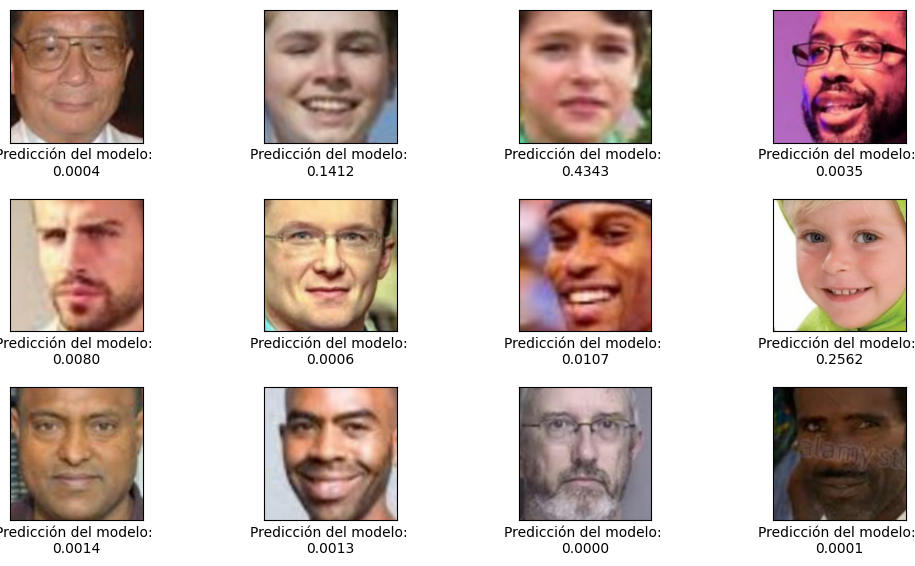

In [33]:
#Imágenes de hombres clasificadas correctamente por el modelo
mostrar_imagenes(masculino_correcto, prediccion_masculino_correcto)

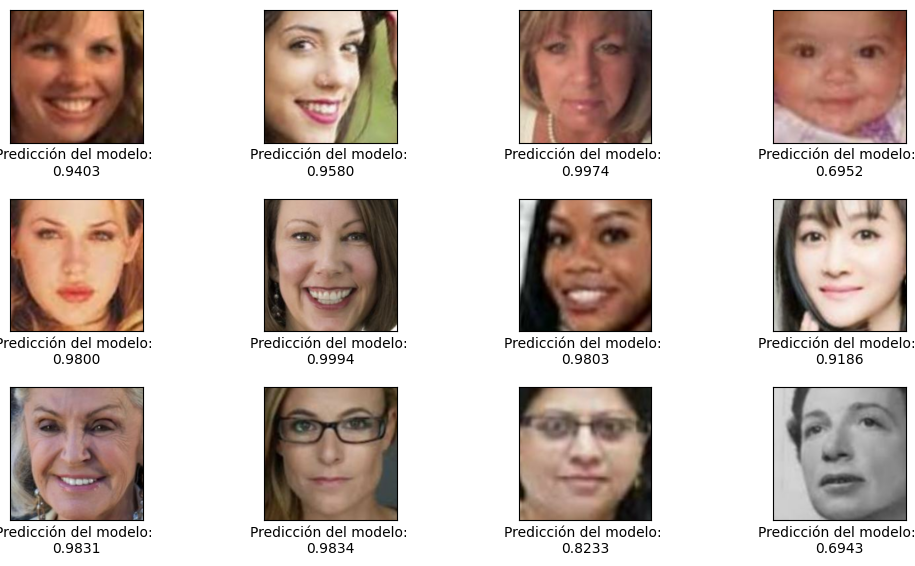

In [34]:
#Imágenes de mujeres clasificadas correctamente por el modelo
mostrar_imagenes(femenino_correcto, prediccion_femenino_correcto)

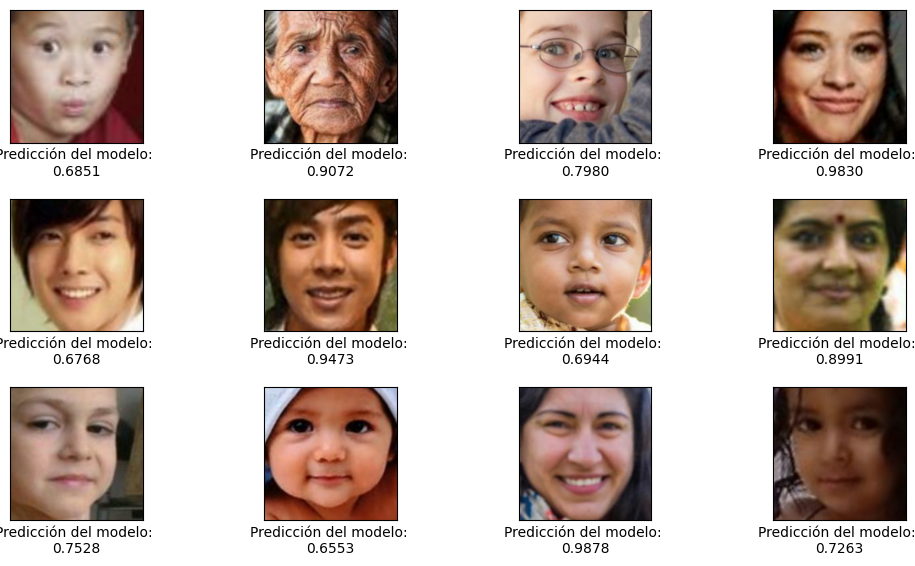

In [35]:
#Imágenes de hombres clasificadas incorrectamente por el modelo como mujeres
mostrar_imagenes(masculino_incorrecto, prediccion_masculino_incorrecto)

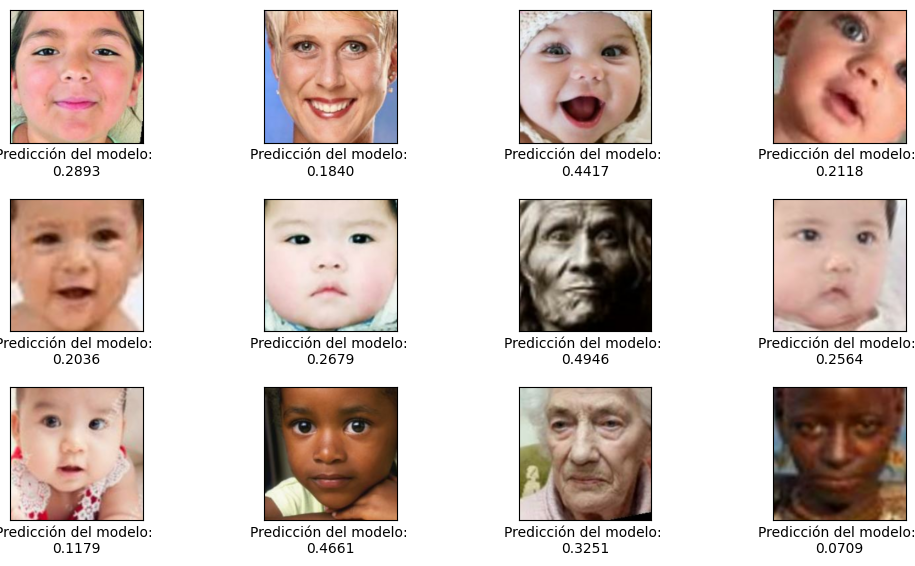

In [36]:
#Imágenes de mujeres clasificadas incorrectamente por el modelo como hombres
mostrar_imagenes(femenino_incorrecto, prediccion_femenino_incorrecto)

#### Observaciones: Los resultados son aceptables. El modelo es bastante bueno.